In [62]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
import pyro
import pyro.distributions as dist

import tqdm

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

test_x = torch.linspace(0, 1, 51)
test_y = torch.sin(test_x * (2 * math.pi)) + torch.randn(test_x.size()) * math.sqrt(0.04)

In [193]:
# We will use the simplest form of GP model, exact inference

class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def compute_NLPD(train_x, train_y, test_y, n_samples = 5, training_iter = 100):
    
    loss_list = np.zeros((n_samples, training_iter))
    nlpd_list = np.zeros(n_samples)

    for s in range(n_samples):
        pyro.clear_param_store()
        
        # initialize likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood)
        
        # this is for running the notebook in our testing framework
        training_iter = training_iter
        
        

        # Find optimal model hyperparameters
        model.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        
        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss_list[s,i] = loss.item()
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            trained_pred_dist = likelihood(model(test_x))
            predictive_mean = trained_pred_dist.mean # same as trained_pred_dist.loc or 
            lower, upper = trained_pred_dist.confidence_region()
            
        nlpd_list[s] = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, test_y)
        print(gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, test_y))
    
    return nlpd_list

In [194]:
nlpd = compute_NLPD(train_x, train_y, test_y)

tensor(-0.3140)
tensor(-0.3140)
tensor(-0.3140)
tensor(-0.3140)
tensor(-0.3140)


In [202]:
print(f'Trained model NLPD: {nlpd[4]:.6f}')

Trained model NLPD: -0.313957


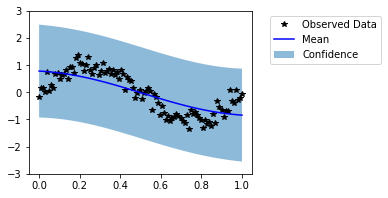

In [7]:
model.eval()
with torch.no_grad():
    untrained_pred_dist = likelihood(model(test_x))
    predictive_mean = untrained_pred_dist.mean
    lower, upper = untrained_pred_dist.confidence_region()

f, ax = plt.subplots(1, 1, figsize=(4, 3))
# Plot training data as black stars
ax.plot(train_x, train_y, 'k*')
# Plot predictive means as blue line
ax.plot(test_x, predictive_mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6,1));

Iter 1/100 - Loss: 0.039001   lengthscale: 0.280   noise: 0.049
Iter 2/100 - Loss: 0.042759   lengthscale: 0.257   noise: 0.054
Iter 3/100 - Loss: 0.039252   lengthscale: 0.274   noise: 0.050
Iter 4/100 - Loss: 0.039852   lengthscale: 0.291   noise: 0.047
Iter 5/100 - Loss: 0.041196   lengthscale: 0.299   noise: 0.045
Iter 6/100 - Loss: 0.040507   lengthscale: 0.296   noise: 0.046
Iter 7/100 - Loss: 0.039339   lengthscale: 0.288   noise: 0.047
Iter 8/100 - Loss: 0.039027   lengthscale: 0.279   noise: 0.049
Iter 9/100 - Loss: 0.039572   lengthscale: 0.272   noise: 0.051
Iter 10/100 - Loss: 0.040067   lengthscale: 0.269   noise: 0.051
Iter 11/100 - Loss: 0.039948   lengthscale: 0.269   noise: 0.051
Iter 12/100 - Loss: 0.039433   lengthscale: 0.273   noise: 0.050
Iter 13/100 - Loss: 0.039042   lengthscale: 0.279   noise: 0.049
Iter 14/100 - Loss: 0.039077   lengthscale: 0.285   noise: 0.048
Iter 15/100 - Loss: 0.039390   lengthscale: 0.289   noise: 0.047
Iter 16/100 - Loss: 0.039583   len

<AxesSubplot:>

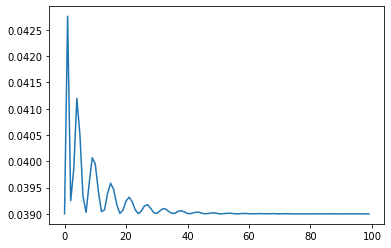

In [141]:
sns.lineplot(np.arange(0, len(loss_list)), loss_list)

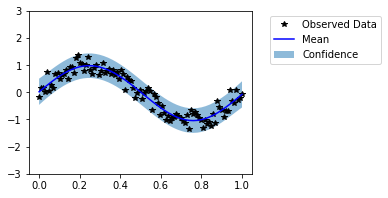

In [142]:


f, ax = plt.subplots(1, 1, figsize=(4, 3))
# Plot training data as black stars
ax.plot(train_x, train_y, 'k*')
# Plot predictive means as blue line
ax.plot(test_x, predictive_mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6,1));

In [143]:
init_nlpd = gpytorch.metrics.negative_log_predictive_density(untrained_pred_dist, test_y)
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, test_y)

print(f'Untrained model NLPD: {init_nlpd:.6f}, \nTrained model NLPD: {final_nlpd:.6f}')

Untrained model NLPD: 0.861908, 
Trained model NLPD: -0.316666


(-3.0, 3.0)

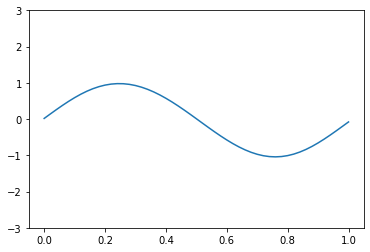

In [144]:
sns.lineplot(test_x, trained_pred_dist.loc)
plt.ylim([-3, 3])

In [145]:
trained_pred_dist.loc

tensor([ 0.0179,  0.1398,  0.2601,  0.3767,  0.4876,  0.5909,  0.6847,  0.7675,
         0.8379,  0.8949,  0.9376,  0.9654,  0.9781,  0.9755,  0.9580,  0.9258,
         0.8797,  0.8204,  0.7489,  0.6662,  0.5736,  0.4723,  0.3638,  0.2496,
         0.1311,  0.0099, -0.1122, -0.2336, -0.3525, -0.4672, -0.5758, -0.6768,
        -0.7684, -0.8489, -0.9171, -0.9715, -1.0110, -1.0349, -1.0425, -1.0335,
        -1.0081, -0.9665, -0.9095, -0.8381, -0.7538, -0.6580, -0.5527, -0.4399,
        -0.3218, -0.2006, -0.0787])

In [ ]:
torch.copy

In [159]:
type(trained_pred_dist)

gpytorch.distributions.multivariate_normal.MultivariateNormal

In [162]:
print(vars(trained_pred_dist))

{'_islazy': True, 'loc': tensor([ 0.0167,  0.1237,  0.2398,  0.3865,  0.4849,  0.5591,  0.6613,  0.7143,
         0.8485,  0.9320,  0.9789,  0.9411,  1.0171,  0.9576,  0.9469,  0.9177,
         0.8875,  0.7990,  0.7598,  0.6522,  0.5932,  0.3915,  0.3309,  0.2512,
         0.1333,  0.0278, -0.1300, -0.2577, -0.3917, -0.4732, -0.5478, -0.6595,
        -0.7494, -0.8239, -0.8973, -0.9939, -1.0151, -1.0330, -1.0521, -1.0330,
        -1.0161, -0.9738, -0.9141, -0.8703, -0.7157, -0.6347, -0.5446, -0.4257,
        -0.3451, -0.2114, -0.0872]), '_covar': <linear_operator.operators.added_diag_linear_operator.AddedDiagLinearOperator object at 0x7fa88616da30>, '_MultivariateNormal__unbroadcasted_scale_tril': None, '_validate_args': False, '_batch_shape': torch.Size([]), '_event_shape': torch.Size([51]), 'lazy_covariance_matrix': <linear_operator.operators.added_diag_linear_operator.AddedDiagLinearOperator object at 0x7fa88616da30>}


In [168]:
gpytorch.distributions.multivariate_normal.MultivariateNormal?

Init signature:
gpytorch.distributions.multivariate_normal.MultivariateNormal(
    mean,
    covariance_matrix,
    validate_args=False,
)
Docstring:     
Constructs a multivariate normal random variable, based on mean and covariance.
Can be multivariate, or a batch of multivariate normals

Passing a vector mean corresponds to a multivariate normal.
Passing a matrix mean corresponds to a batch of multivariate normals.

:param torch.tensor mean: Vector n or matrix b x n mean of mvn distribution.
:param ~linear_operator.operators.LinearOperator covar: ... x N X N covariance matrix of
    mvn distribution.
File:           ~/miniconda3/envs/pytorch/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py
Type:           DistributionMeta
Subclasses:     MultitaskMultivariateNormal


In [150]:
print(dir(trained_pred_dist))

['_MultivariateNormal__unbroadcasted_scale_tril', '__abstractmethods__', '__add__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__signature__', '__sizeof__', '__str__', '__subclasshook__', '__truediv__', '__weakref__', '_abc_impl', '_batch_shape', '_covar', '_event_shape', '_extended_shape', '_get_checked_instance', '_islazy', '_repr_sizes', '_unbroadcasted_scale_tril', '_validate_args', '_validate_sample', 'add_jitter', 'arg_constraints', 'base_sample_shape', 'batch_shape', 'cdf', 'confidence_region', 'conjugate_update', 'covariance_matrix', 'entropy', 'enumerate_support', 'event_dim', 'event_shape', 'expand', 'expand_by', 'get_base_samples', 'has_enumerate_support', 'has_rsample', 'has_r

In [146]:
model.eval()
with torch.no_grad():
    trained_pred_dist_1 = trained_pred_dist
    n_sample = 100
    loc_sample = torch.zeros((n_sample, trained_pred_dist.loc.numel()))

    for i in range(n_sample):
        loc_sample[i] = trained_pred_dist_1()
        
    trained_pred_dist_1.loc = loc_sample.mean(-0)

(-3.0, 3.0)

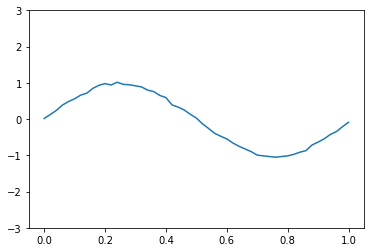

In [147]:
sns.lineplot(test_x, loc_sample.mean(-0))
plt.ylim([-3, 3]) 

In [148]:
trained_pred_dist_1.loc

tensor([ 0.0167,  0.1237,  0.2398,  0.3865,  0.4849,  0.5591,  0.6613,  0.7143,
         0.8485,  0.9320,  0.9789,  0.9411,  1.0171,  0.9576,  0.9469,  0.9177,
         0.8875,  0.7990,  0.7598,  0.6522,  0.5932,  0.3915,  0.3309,  0.2512,
         0.1333,  0.0278, -0.1300, -0.2577, -0.3917, -0.4732, -0.5478, -0.6595,
        -0.7494, -0.8239, -0.8973, -0.9939, -1.0151, -1.0330, -1.0521, -1.0330,
        -1.0161, -0.9738, -0.9141, -0.8703, -0.7157, -0.6347, -0.5446, -0.4257,
        -0.3451, -0.2114, -0.0872])

In [149]:
trained_pred_dist.loc

tensor([ 0.0167,  0.1237,  0.2398,  0.3865,  0.4849,  0.5591,  0.6613,  0.7143,
         0.8485,  0.9320,  0.9789,  0.9411,  1.0171,  0.9576,  0.9469,  0.9177,
         0.8875,  0.7990,  0.7598,  0.6522,  0.5932,  0.3915,  0.3309,  0.2512,
         0.1333,  0.0278, -0.1300, -0.2577, -0.3917, -0.4732, -0.5478, -0.6595,
        -0.7494, -0.8239, -0.8973, -0.9939, -1.0151, -1.0330, -1.0521, -1.0330,
        -1.0161, -0.9738, -0.9141, -0.8703, -0.7157, -0.6347, -0.5446, -0.4257,
        -0.3451, -0.2114, -0.0872])

In [12]:
final_nlpd

tensor(-0.3140)

In [13]:
trained_pred_dist.loc

tensor([ 0.0188,  0.1405,  0.2606,  0.3769,  0.4876,  0.5906,  0.6843,  0.7670,
         0.8374,  0.8944,  0.9371,  0.9650,  0.9778,  0.9755,  0.9581,  0.9261,
         0.8800,  0.8208,  0.7494,  0.6667,  0.5740,  0.4727,  0.3641,  0.2497,
         0.1311,  0.0098, -0.1125, -0.2340, -0.3529, -0.4676, -0.5763, -0.6772,
        -0.7687, -0.8491, -0.9171, -0.9714, -1.0108, -1.0345, -1.0420, -1.0330,
        -1.0075, -0.9660, -0.9091, -0.8378, -0.7536, -0.6580, -0.5528, -0.4402,
        -0.3222, -0.2011, -0.0792])

In [14]:
model.

SyntaxError: invalid syntax (1068564517.py, line 1)

In [15]:
trained_pred_dist.log_prob(test_y) / 51

tensor(0.3140)

In [16]:
-pred_dist.log_prob(test_y) / test_y.shape[combine_dim]

NameError: name 'pred_dist' is not defined

In [ ]:
test_y.shape[-1]

51

In [17]:
trained_pred_dist()

tensor([-1.9984e-01,  3.0211e-01,  5.6659e-01,  2.7881e-01,  5.8403e-01,
         5.4622e-01,  4.9581e-01,  9.2842e-01,  8.9826e-01,  1.0665e+00,
         8.2810e-01,  1.1953e+00,  7.2581e-01,  1.1757e+00,  1.2818e+00,
         7.4929e-01,  8.5083e-01,  8.8211e-01,  5.1269e-01,  9.0540e-01,
         2.1961e-01,  4.8000e-01,  6.0496e-01,  6.4999e-05,  4.2189e-02,
        -9.1953e-02, -3.5214e-01, -4.3590e-01, -3.5726e-01, -6.5671e-01,
        -7.9774e-01, -8.2838e-01, -7.9333e-01, -7.0744e-01, -8.8711e-01,
        -9.6378e-01, -1.1926e+00, -1.0348e+00, -1.1188e+00, -1.4893e+00,
        -9.7025e-01, -1.0657e+00, -1.1673e+00, -1.0904e+00, -1.1363e+00,
        -7.1514e-01, -5.9687e-01,  2.4734e-01, -7.6469e-02, -2.1832e-01,
         7.3982e-02])

In [18]:
likelihood(model(test_x)).loc

tensor([ 0.0188,  0.1405,  0.2606,  0.3769,  0.4876,  0.5906,  0.6843,  0.7670,
         0.8374,  0.8944,  0.9371,  0.9650,  0.9778,  0.9755,  0.9581,  0.9261,
         0.8800,  0.8208,  0.7494,  0.6667,  0.5740,  0.4727,  0.3641,  0.2497,
         0.1311,  0.0098, -0.1125, -0.2340, -0.3529, -0.4676, -0.5763, -0.6772,
        -0.7687, -0.8491, -0.9171, -0.9714, -1.0108, -1.0345, -1.0420, -1.0330,
        -1.0075, -0.9660, -0.9091, -0.8378, -0.7536, -0.6580, -0.5528, -0.4402,
        -0.3222, -0.2011, -0.0792], grad_fn=<ViewBackward0>)

In [19]:
likelihood(model(test_x)).loc

tensor([ 0.0188,  0.1405,  0.2606,  0.3769,  0.4876,  0.5906,  0.6843,  0.7670,
         0.8374,  0.8944,  0.9371,  0.9650,  0.9778,  0.9755,  0.9581,  0.9261,
         0.8800,  0.8208,  0.7494,  0.6667,  0.5740,  0.4727,  0.3641,  0.2497,
         0.1311,  0.0098, -0.1125, -0.2340, -0.3529, -0.4676, -0.5763, -0.6772,
        -0.7687, -0.8491, -0.9171, -0.9714, -1.0108, -1.0345, -1.0420, -1.0330,
        -1.0075, -0.9660, -0.9091, -0.8378, -0.7536, -0.6580, -0.5528, -0.4402,
        -0.3222, -0.2011, -0.0792], grad_fn=<ViewBackward0>)

In [20]:
likelihood(model(test_x)).loc

tensor([ 0.0188,  0.1405,  0.2606,  0.3769,  0.4876,  0.5906,  0.6843,  0.7670,
         0.8374,  0.8944,  0.9371,  0.9650,  0.9778,  0.9755,  0.9581,  0.9261,
         0.8800,  0.8208,  0.7494,  0.6667,  0.5740,  0.4727,  0.3641,  0.2497,
         0.1311,  0.0098, -0.1125, -0.2340, -0.3529, -0.4676, -0.5763, -0.6772,
        -0.7687, -0.8491, -0.9171, -0.9714, -1.0108, -1.0345, -1.0420, -1.0330,
        -1.0075, -0.9660, -0.9091, -0.8378, -0.7536, -0.6580, -0.5528, -0.4402,
        -0.3222, -0.2011, -0.0792], grad_fn=<ViewBackward0>)

In [21]:
testing = likelihood(model(test_x))
test_mean = testing.mean

In [22]:
testing.loc == test_mean

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])

In [23]:
test_mean

tensor([ 0.0188,  0.1405,  0.2606,  0.3769,  0.4876,  0.5906,  0.6843,  0.7670,
         0.8374,  0.8944,  0.9371,  0.9650,  0.9778,  0.9755,  0.9581,  0.9261,
         0.8800,  0.8208,  0.7494,  0.6667,  0.5740,  0.4727,  0.3641,  0.2497,
         0.1311,  0.0098, -0.1125, -0.2340, -0.3529, -0.4676, -0.5763, -0.6772,
        -0.7687, -0.8491, -0.9171, -0.9714, -1.0108, -1.0345, -1.0420, -1.0330,
        -1.0075, -0.9660, -0.9091, -0.8378, -0.7536, -0.6580, -0.5528, -0.4402,
        -0.3222, -0.2011, -0.0792], grad_fn=<ViewBackward0>)

In [24]:
with torch.no_grad():
    testing = likelihood(model(test_x))
    test_mean = testing.mean

In [25]:
predictive_mean

tensor([ 0.0188,  0.1405,  0.2606,  0.3769,  0.4876,  0.5906,  0.6843,  0.7670,
         0.8374,  0.8944,  0.9371,  0.9650,  0.9778,  0.9755,  0.9581,  0.9261,
         0.8800,  0.8208,  0.7494,  0.6667,  0.5740,  0.4727,  0.3641,  0.2497,
         0.1311,  0.0098, -0.1125, -0.2340, -0.3529, -0.4676, -0.5763, -0.6772,
        -0.7687, -0.8491, -0.9171, -0.9714, -1.0108, -1.0345, -1.0420, -1.0330,
        -1.0075, -0.9660, -0.9091, -0.8378, -0.7536, -0.6580, -0.5528, -0.4402,
        -0.3222, -0.2011, -0.0792])